One of the more interesting geopolitical trends in the past few decades is watching China emerge from semi-isolation into one of the major economic players on the world stage.  A spin out of this trend has been China's investment in Africa over the past few decades.  This data analysis was inspired by this [Youtube Video](https://www.youtube.com/watch?v=zQV_DKQkT8o).  In summary, China has been using econnic infrastructure projects and loans to sway African countires into voting along China's agenda.  I was interested in how these investments have played out in terms of ecological balance. The [Global Footprint Network](https://www.footprintnetwork.org/our-work/ecological-footprint/) is organization that collects and compiles data on how different countries are using certain types of land.  They define ecological balance as the difference between a country's ecological footprint and biocapacity.  In short, does the country consume more or less than its land can produce.  In this anaylsis, I will attempt to see if countries that tend to vote with China have had a change in ecological balance trends possiabley due to more economic investment.  

In [10]:
#Let's first import some important libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy.polynomial.polynomial import polyfit

First we need to figure out which countries vote with and against China.  The video talks about a UN resolution in 2007 against North Korea (China's ally) as being a marker for this economic influence. Thus, African countries that rejected the resolution or abstained can be considered allies of China while those who approved the resolution we can consider opposition. 

We can webscape the wikipedia article on the resolution to get how each country voted.  Note: I tried using beautifulsoup and ended up down a rabbit hole which was a good learning experience but a big shout out to pandas "pd.read_html" for being simpler in this case

In [11]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/United_Nations_General_Assembly_Resolution_62/167') 
voting = dfs[1]
approve = voting.iloc[1,2].split(",")
reject = voting.iloc[2,2].split(",")
abstain = voting.iloc[3,2].split(",")  

Great, now we have a list of how different countries voted in the resolution.  Let's next grab the land use data provided by the Global Footprint Network.  I orignally found this data on Kaggle [here](https://www.kaggle.com/footprintnetwork/national-footprint-accounts-2018) and downloaded the .csv file to my local computer. 

In [12]:
data = pd.read_csv('NFA 2018.csv')


As in all good analysis, let's get a feel for what this data looks like 

In [13]:
print(data.head())
print(data.columns)


   country ISO alpha-3 code UN_region  UN_subregion  year           record  \
0  Armenia              ARM      Asia  Western Asia  1992     BiocapPerCap   
1  Armenia              ARM      Asia  Western Asia  1992     BiocapTotGHA   
2  Armenia              ARM      Asia  Western Asia  1992     EFConsPerCap   
3  Armenia              ARM      Asia  Western Asia  1992     EFConsTotGHA   
4  Armenia              ARM      Asia  Western Asia  1992  EFExportsPerCap   

      crop_land   grazing_land    forest_land  fishing_ground  built_up_land  \
0  1.611286e-01       0.135023       0.083836        0.013718       0.033669   
1  5.558130e+05  465763.337400  289190.662300    47320.224590  116139.598200   
2  3.909225e-01       0.189137       0.000001        0.004138       0.033669   
3  1.348487e+06  652429.066600       4.327841    14272.803690  116139.598200   
4  1.124910e-03       0.002283       0.000000        0.000438       0.000000   

         carbon         total  Percapita GDP (2010

Most of these columns and their values make sense looking at the `data.head()` call except the 'records' column.  Let's see what are the data types of each column.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 15 columns):
country                     87020 non-null object
ISO alpha-3 code            85660 non-null object
UN_region                   87020 non-null object
UN_subregion                87020 non-null object
year                        87020 non-null int64
record                      87020 non-null object
crop_land                   63530 non-null float64
grazing_land                63530 non-null float64
forest_land                 63530 non-null float64
fishing_ground              63530 non-null float64
built_up_land               63530 non-null float64
carbon                      63530 non-null float64
total                       87020 non-null float64
Percapita GDP (2010 USD)    71410 non-null float64
population                  87020 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 10.0+ MB


It looks like 'record' is an object so let's look at the types of values found in that column 

In [15]:
data['record'].unique()

array(['BiocapPerCap', 'BiocapTotGHA', 'EFConsPerCap', 'EFConsTotGHA',
       'EFExportsPerCap', 'EFExportsTotGHA', 'EFImportsPerCap',
       'EFImportsTotGHA', 'EFProdPerCap', 'EFProdTotGHA'], dtype=object)

Reading more on the [kaggle](https://www.kaggle.com/footprintnetwork/national-footprint-accounts-2018) description more closely tells us about each label. It seems that the ecologial footprint is defined as the 'total' value corresponding to the 'BiocapTotGHA' record minus the 'total' value corresponding to the 'EFConsTotGHA' record.  In otherwords, the total bio capacity of all the land minus the ecological footprint of consumption.  It would be interesting to look at per GDP but that could be for another time.  For now we will keep those specific records in mind for when we have our data in the shape we want it. 


I also like to run `df.isna().sum()` to see if I can broadly catch any missing data in my dataframe

In [7]:
data.isna().sum()


country                         0
ISO alpha-3 code             1360
UN_region                       0
UN_subregion                    0
year                            0
record                          0
crop_land                   23490
grazing_land                23490
forest_land                 23490
fishing_ground              23490
built_up_land               23490
carbon                      23490
total                           0
Percapita GDP (2010 USD)    15610
population                      0
dtype: int64

Whoa there, seems like theres some missing data.  I am going to leave it for now since this dataframe has the whole world and might be better once we look at just Africa. 

Before we calculate the footprint of each country, however, lets narrow down the dataframe to specifically dealing with Africa. Since in this case we only care about totals and not the break down of land use, we only have to look at the 'year','country','record', 'total', 'UN_subregion' columns.  I threw in 'UN_subregion' because perhaps it'll be interesting to look at the data broken into subregions of the continent

In [32]:
#%% Narrow down dataframe to only include 
africa_data = data[(data['UN_region'] == 'Africa') & (data['year'] >= 1971)]
EF_africa_data = africa_data[(africa_data['record'] == 'EFConsTotGHA') | (africa_data['record'] == 'BiocapTotGHA')]
EF_africa_data = EF_africa_data[['year','country','record', 'total', 'UN_subregion']]

As mentioned let's look to see if those NaN values carried over once we specifically looked at Africa.

In [33]:
africa_data.isna().sum()

country                        0
ISO alpha-3 code             620
UN_region                      0
UN_subregion                   0
year                           0
record                         0
crop_land                   7160
grazing_land                7160
forest_land                 7160
fishing_ground              7160
built_up_land               7160
carbon                      7160
total                          0
Percapita GDP (2010 USD)    3270
population                     0
dtype: int64

It still seems like we have a good chunk of missing data. My inital incling was to group by subregions and do some sort of forward filling on a mean.  Looking more closely at what The Global Footprint Network organization wrote in their descrpition, however, revels that they intentionally left out data that was unreliable and only put the "totals."  Thus, since we're only interested in the totals, we can ignore the missing data in the specific land type and trust the "total" values are correct. 

Now that we have the Africa specific dataframe, let's calculate the ecological balance per country per year.  My inital thought was to use some type of nested for loops with an if statement and making new dataframes, howver, that seemed dreadfully complicated and not very pythonic.  Thinking about it a bit more, I remembered that pd.pivot_table might be useful since 'EFConsTotGHA' and 'BiocapTotGHA' are in rows but I want their values in columns per country per year.  Having them in columns will just let me do element by element subtraction and avoid the whole for loop fiasco. 

In [34]:
EF_africa_data = pd.pivot_table(EF_africa_data,index = ['year','country', 'UN_subregion'], columns = ['record'])
print(EF_africa_data.head())
print(EF_africa_data.columns)

                                          total              
record                             BiocapTotGHA  EFConsTotGHA
year country      UN_subregion                               
1971 Algeria      Northern Africa  1.738149e+07  1.202935e+07
     Angola       Middle Africa    5.285846e+07  8.065615e+06
     Benin        Western Africa   7.268030e+06  3.742947e+06
     Botswana     Southern Africa  7.491169e+06  2.001873e+06
     Burkina Faso Western Africa   1.042982e+07  7.494312e+06
MultiIndex(levels=[['total'], ['BiocapTotGHA', 'EFConsTotGHA']],
           labels=[[0, 0], [0, 1]],
           names=[None, 'record'])


Cool we are sorta close to what we want, however, there seems to be multiindexed levels for our columns with 'total' being the top columns.  Digging around stackoverflow we can drop the 'total' level and subtract the columns to find the ecological balance. 

In [35]:
EF_africa_data.columns = EF_africa_data.columns.droplevel()
EF_africa_data['Ecological_Balance'] = EF_africa_data.BiocapTotGHA - EF_africa_data.EFConsTotGHA

Finally, we can unstack the year and country index to have a nice data frame with the ecological balance per country per year. 

In [36]:
EF_africa_data.reset_index(level=[0,1,2], inplace=True)
print(EF_africa_data.head())

record  year       country     UN_subregion  BiocapTotGHA  EFConsTotGHA  \
0       1971       Algeria  Northern Africa  1.738149e+07  1.202935e+07   
1       1971        Angola    Middle Africa  5.285846e+07  8.065615e+06   
2       1971         Benin   Western Africa  7.268030e+06  3.742947e+06   
3       1971      Botswana  Southern Africa  7.491169e+06  2.001873e+06   
4       1971  Burkina Faso   Western Africa  1.042982e+07  7.494312e+06   

record  Ecological_Balance  
0             5.352138e+06  
1             4.479284e+07  
2             3.525082e+06  
3             5.489296e+06  
4             2.935505e+06  


Now we need to seperate the dataframe into the voting patterns using an `.isin()` method.  Not shown here was me figuring out that when I webscraped the countries into a list there was an extra space added which caused the `.isin()` method to never match the countries.  This was solved with the .strip() method shown below

In [37]:
#%% Now need to seperate dataframe into countries that voted with china (abstain/aganist) and voted against china (for resolution)
approve = [x.strip(' ') for x in approve]
reject = [x.strip(' ') for x in reject]
abstain = [x.strip(' ') for x in abstain]

with_countries = EF_africa_data[(EF_africa_data['country'].isin(reject)) | (EF_africa_data['country'].isin(abstain))]
against_countries = EF_africa_data[EF_africa_data['country'].isin(approve)]

Great now we can plot the ecological balance vs year to see how allies and opposition to China differ.  For now, let's look at the average of all the countries. 

Text(0.5, 1.0, 'Total Continent')

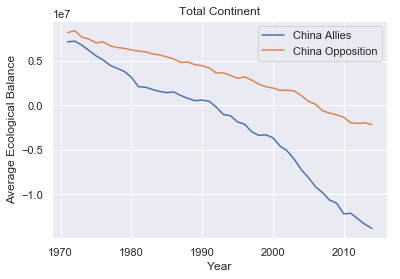

In [40]:
#%% Plot China's Allies vs China's Opposition in the UN... Comeback and write this into a function
mean_with = with_countries.groupby('year', as_index=False)['Ecological_Balance'].mean()
mean_against = against_countries.groupby('year', as_index=False)['Ecological_Balance'].mean()

plt.figure()
plt.plot(mean_with['year'], mean_with['Ecological_Balance'], mean_against['year'], mean_against['Ecological_Balance'])
plt.legend(['China Allies', 'China Opposition'])
plt.ylabel('Average Ecological Balance')
plt.xlabel('Year')
plt.title('Total Continent')


This seems sort of interesting.  Both allies and opposition seem to have a downward trend 

In [5]:
#%% Plot China's Allies vs China's Opposition in the UN... Comeback and write this into a function
mean_with = with_countries.groupby('year', as_index=False)['Ecological_Balance'].mean()
mean_against = against_countries.groupby('year', as_index=False)['Ecological_Balance'].mean()


#Want to see the trend before China started investing from: "http://www.sais-cari.org/data-chinese-contracts-in-africa"

def plot_year_fit(data, y_data, year):
    '''
    Intakes- data set and plots the best fit of year vs y_data variable up until a certain year
        needs to have year column 
    outputs- slope m and intercept b values for best fit 
    data- data to look at
    y_data- data to plot vs year
    year- year to go up to 
    '''
    x = data[data['year']  <= year]['year']
    y = data[data['year']  <= year][y_data]
    b, m = polyfit(x, y, 1)
    return (b,m)

pre_b, pre_m = plot_year_fit(mean_with, 'Ecological_Balance', 2000)
pre_against_b, pre_against_m = plot_year_fit(mean_against, 'Ecological_Balance', 2000)


plt.figure(1)
plt.plot(mean_with['year'], mean_with['Ecological_Balance'], mean_against['year'], mean_against['Ecological_Balance'])
plt.plot(mean_with['year'], pre_b + pre_m * mean_with['year'], '-')
plt.plot(mean_against['year'], pre_against_b + pre_against_m * mean_against['year'], '-')
plt.legend(['China Allies', 'China Opposition', 'Fit until 2000', 'Fit until 2000'])
plt.plot()
plt.ylabel('Average Ecological Balance')
plt.xlabel('Year')
plt.title('Total Continent')


NameError: name 'with_countries' is not defined

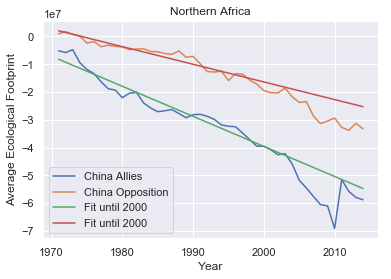

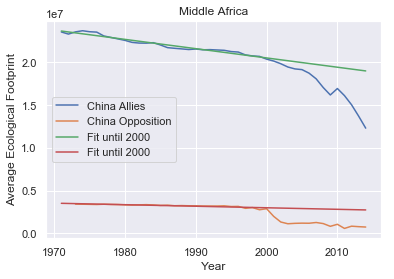

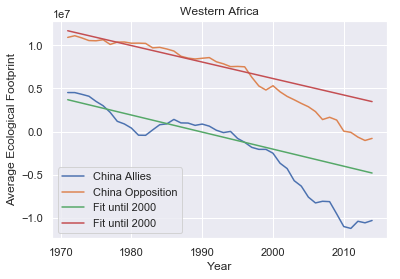

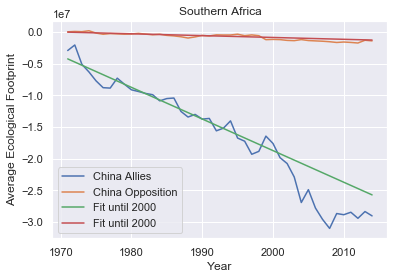

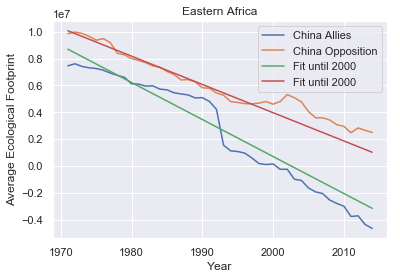

In [13]:
#%% Now we want to break it down into subregion 
subregion_with = with_countries.groupby(['year', 'UN_subregion'], as_index=False)['Ecological_Balance'].mean()
subregion_against = against_countries.groupby(['year', 'UN_subregion'], as_index=False)['Ecological_Balance'].mean()


region_list =  list(EF_africa_data['UN_subregion'].unique())
for region in region_list:
    plt.figure()
    with_plot_data = subregion_with[subregion_with['UN_subregion'] == region]
    aganist_plot_data = subregion_against[subregion_against['UN_subregion'] == region]
    
    pre_b, pre_m = plot_year_fit(with_plot_data, 'Ecological_Balance', 2000)
    pre_against_b, pre_against_m = plot_year_fit(aganist_plot_data, 'Ecological_Balance', 2000)
    
    plt.plot(with_plot_data['year'], with_plot_data['Ecological_Balance'], aganist_plot_data['year'], aganist_plot_data['Ecological_Balance'])                          
    plt.plot(mean_with['year'], pre_b + pre_m * mean_with['year'], '-')
    plt.plot(mean_against['year'], pre_against_b + pre_against_m * mean_against['year'], '-')
    plt.legend(['China Allies', 'China Opposition', 'Fit until 2000', 'Fit until 2000'])
    plt.plot()
    plt.ylabel('Average Ecological Balance')
    plt.xlabel('Year')
    plt.title(region)